#WGAN with LSTM

## Importing Libraries

In [ ]:
import os
import keras
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Dropout, multiply, Concatenate
from tensorflow.keras.layers import BatchNormalization, Activation, Embedding, ZeroPadding2D, LeakyReLU
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.initializers import RandomNormal
import tensorflow.keras.backend as K
from sklearn.utils import shuffle
from sklearn.metrics import precision_score, recall_score, f1_score,\
                            accuracy_score, balanced_accuracy_score,classification_report,\
                            confusion_matrix

In [ ]:
import tensorflow as tf
tf.config.run_functions_eagerly(True)


## EDA

In [ ]:
df=pd.read_csv('./creditcard.csv')
df=df.drop('Time',axis=1)
df.head()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 30 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   V1      284807 non-null  float64
 1   V2      284807 non-null  float64
 2   V3      284807 non-null  float64
 3   V4      284807 non-null  float64
 4   V5      284807 non-null  float64
 5   V6      284807 non-null  float64
 6   V7      284807 non-null  float64
 7   V8      284807 non-null  float64
 8   V9      284807 non-null  float64
 9   V10     284807 non-null  float64
 10  V11     284807 non-null  float64
 11  V12     284807 non-null  float64
 12  V13     284807 non-null  float64
 13  V14     284807 non-null  float64
 14  V15     284807 non-null  float64
 15  V16     284807 non-null  float64
 16  V17     284807 non-null  float64
 17  V18     284807 non-null  float64
 18  V19     284807 non-null  float64
 19  V20     284807 non-null  float64
 20  V21     284807 non-null  float64
 21  V22     28

PCA Transformation: The description of the data says that all the features went through a PCA transformation (Except for time and amount).  
Scaling: Keep in mind that in order to implement a PCA transformation features need to be previously scaled.

In [ ]:
df.describe()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,1.168375e-15,3.416908e-16,-1.379537e-15,2.074095e-15,9.604066e-16,1.487313e-15,-5.556467e-16,1.213481e-16,-2.406331e-15,2.239053e-15,...,1.654067e-16,-3.568593e-16,2.578648e-16,4.473266e-15,5.340915e-16,1.683437e-15,-3.660091e-16,-1.227390e-16,88.349619,0.001727
std,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,1.088850e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,-2.458826e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,-5.354257e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,-9.291738e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,4.539234e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,2.374514e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


In [ ]:
# checking for duplicate values
print(f"Dataset has {df.duplicated().sum()} duplicate rows")
# dropping duplicate rows
df.drop_duplicates(inplace=True)

Dataset has 9144 duplicate rows


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 275663 entries, 0 to 284806
Data columns (total 30 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   V1      275663 non-null  float64
 1   V2      275663 non-null  float64
 2   V3      275663 non-null  float64
 3   V4      275663 non-null  float64
 4   V5      275663 non-null  float64
 5   V6      275663 non-null  float64
 6   V7      275663 non-null  float64
 7   V8      275663 non-null  float64
 8   V9      275663 non-null  float64
 9   V10     275663 non-null  float64
 10  V11     275663 non-null  float64
 11  V12     275663 non-null  float64
 12  V13     275663 non-null  float64
 13  V14     275663 non-null  float64
 14  V15     275663 non-null  float64
 15  V16     275663 non-null  float64
 16  V17     275663 non-null  float64
 17  V18     275663 non-null  float64
 18  V19     275663 non-null  float64
 19  V20     275663 non-null  float64
 20  V21     275663 non-null  float64
 21  V22     275663 

There is no null values

In [ ]:
print('No Frauds', round(df['Class'].value_counts()[0]/len(df) * 100,2), '% of the dataset')
print('Frauds', round(df['Class'].value_counts()[1]/len(df) * 100,2), '% of the dataset')

No Frauds 99.83 % of the dataset
Frauds 0.17 % of the dataset


<Axes: xlabel='Class', ylabel='count'>

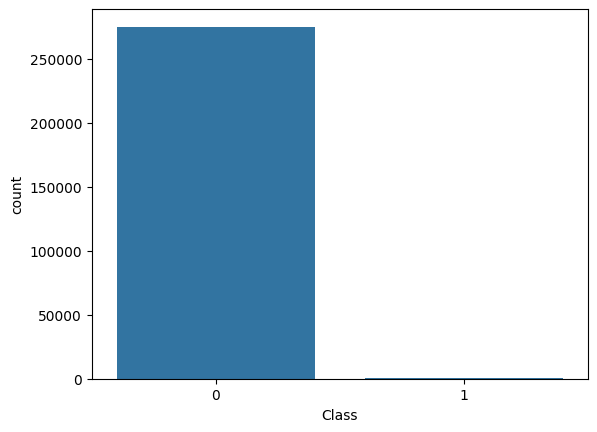

In [ ]:
sns.countplot(data=df,x='Class')

In [ ]:
df.drop('Class',axis=1).skew()

,0
V1,-3.273070
V2,-4.653486
V3,-2.216730
V4,0.681387
V5,-2.458790
V6,1.867576
V7,2.877722
V8,-8.292631
V9,0.550965
V10,1.242165


## Scaling

In [ ]:
scaler = StandardScaler()
X = scaler.fit_transform(df.drop('Class', axis=1))
y = df['Class'].values
print(X.shape, y.shape)

(275663, 29) (275663,)


## Splitting the data

we want to test our models on the original testing set not on the testing set created from GAN. The main goal is to fit the model in the generated data, and test it on the original testing set.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

## Testing baseline model with original data

In [ ]:

def wasserstein_loss(y_true, y_pred):
      return K.mean(y_true * y_pred)

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, LeakyReLU, Dropout, Flatten
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.initializers import RandomNormal
import numpy as np

class WGAN:
    def __init__(self):
        self.latent_dim = 32
        self.out_shape = 29
        self.n_critic = 5  # Train discriminator more than generator
        self.clip_value = 0.01  # weight clipping range
        self.batch_size = 64

        self.critic = self.build_critic()
        self.critic.compile(loss=wasserstein_loss,
                            optimizer=RMSprop(learning_rate=0.00005))

        self.generator = self.build_generator()

        # Combined model
        z = Input(shape=(self.latent_dim,))
        fake_sample = self.generator(z)
        self.critic.trainable = False
        valid = self.critic(fake_sample)

        self.combined = Model(z, valid)
        self.combined.compile(loss=wasserstein_loss, optimizer=RMSprop(learning_rate=0.00005))

    def build_generator(self):
        model = tf.keras.Sequential()
        model.add(Dense(128, input_dim=self.latent_dim))
        model.add(LeakyReLU(0.2))
        model.add(Dense(256))
        model.add(LeakyReLU(0.2))
        model.add(Dense(512))
        model.add(LeakyReLU(0.2))
        model.add(Dense(self.out_shape, activation='tanh'))

        z = Input(shape=(self.latent_dim,))
        gen_sample = model(z)
        return Model(z, gen_sample)



    def build_critic(self):
        model = tf.keras.Sequential()
        model.add(Dense(512, input_dim=self.out_shape))
        model.add(LeakyReLU(0.2))
        model.add(Dropout(0.4))
        model.add(Dense(256))
        model.add(LeakyReLU(0.2))
        model.add(Dense(1))  # No activation

        sample = Input(shape=(self.out_shape,))
        validity = model(sample)
        return Model(sample, validity)

    def train(self, X_train, epochs=10000, batch_size=64, sample_interval=500):
        real = -np.ones((batch_size, 1))
        fake = np.ones((batch_size, 1))

        for epoch in range(epochs):
            for _ in range(self.n_critic):
                idx = np.random.randint(0, X_train.shape[0], batch_size)
                real_samples = X_train[idx]

                noise = np.random.normal(0, 1, (batch_size, self.latent_dim))
                gen_samples = self.generator.predict(noise, verbose=0)

                d_loss_real = self.critic.train_on_batch(real_samples, real)
                d_loss_fake = self.critic.train_on_batch(gen_samples, fake)
                d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

                # Clip weights
                for l in self.critic.layers:
                    weights = l.get_weights()
                    weights = [np.clip(w, -self.clip_value, self.clip_value) for w in weights]
                    l.set_weights(weights)

            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))
            g_loss = self.combined.train_on_batch(noise, real)

            if (epoch + 1) % sample_interval == 0:
                print(f"{epoch+1} [D loss: {d_loss:.4f}] [G loss: {g_loss:.4f}]")


In [ ]:
import numpy as np
import pandas as pd
from lightgbm import LGBMClassifier
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

wgan = WGAN()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:93: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



In [ ]:

wgan.train(X_train, epochs=1000, batch_size=64, sample_interval=100)




100 [D loss: -0.0001] [G loss: -0.0001]
200 [D loss: -0.0001] [G loss: -0.0002]
300 [D loss: -0.0000] [G loss: -0.0002]
400 [D loss: 0.0000] [G loss: -0.0003]
500 [D loss: 0.0000] [G loss: -0.0003]
600 [D loss: 0.0001] [G loss: -0.0004]
700 [D loss: 0.0001] [G loss: -0.0004]
800 [D loss: 0.0001] [G loss: -0.0005]
900 [D loss: 0.0001] [G loss: -0.0006]
1000 [D loss: 0.0002] [G loss: -0.0006]


In [ ]:

n_synth = 250_000
noise = np.random.normal(0, 1, (n_synth, wgan.latent_dim))
gen_samples = wgan.generator.predict(noise, verbose=0)


gen_samples = scaler.inverse_transform(gen_samples)
print("Synthetic shape:", gen_samples.shape)


gen_df = pd.DataFrame(gen_samples, columns=df.drop('Class', axis=1).columns)
print(gen_df.head())


gen_X_train = np.vstack([X_train, gen_samples])
print("Augmented X_train shape:", gen_X_train.shape)


Synthetic shape: (250000, 29)
         V1        V2        V3        V4        V5        V6        V7  \
0 -0.717968 -0.052108  0.661178  0.130961 -0.371152 -0.060576  0.023392   
1 -0.605666 -0.281540  0.017258  0.314159 -0.839001 -0.501734 -0.150575   
2 -1.119674  0.014651  0.001414 -0.326555 -0.671793 -0.585157  0.211825   
3 -0.864046 -0.337263  0.403923 -0.315277 -0.811422 -0.503442 -0.161072   
4 -0.445996 -0.236499  0.577711  0.246859 -0.578266 -0.453376  0.017432   

         V8        V9       V10  ...       V20       V21       V22       V23  \
0  0.488095  0.561829  0.647777  ...  0.194683  0.286357 -0.054552  0.084128   
1  0.485086  0.439021  0.478150  ...  0.097521  0.266905  0.013065  0.200128   
2  0.668767  0.640191  0.584453  ...  0.302010  0.270857 -0.244908  0.408388   
3  0.751271  0.464345  0.764550  ...  0.446245  0.249590 -0.142113  0.374526   
4  0.276946  0.214113  0.650764  ...  0.249730  0.257493 -0.097366  0.239140   

        V24       V25       V26       

In [ ]:

gen_y = np.ones((n_synth, 1), dtype='int32')
y_train = y_train.reshape(-1, 1)
gen_y_train = np.vstack([y_train, gen_y])
print("Augmented y_train shape:", gen_y_train.shape)



Augmented y_train shape: (470530, 1)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 50)             │        16,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,051 (62.70 KB)

 Trainable params: 16,051 (62.70 KB)

 Non-trainable params: 0 (0.00 B)

/usr/local/lib/python3.11/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning:

Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.



Epoch 1/5
14704/14704 - 5424s - 369ms/step - loss: 0.0070 - pr_auc: 0.9999 - precision: 0.9977 - recall: 0.9991 - roc_auc: 0.9998 - val_loss: 0.0028 - val_pr_auc: 0.7944 - val_precision: 0.8966 - val_recall: 0.8211 - val_roc_auc: 0.9468
Epoch 2/5
14704/14704 - 5492s - 374ms/step - loss: 0.0016 - pr_auc: 0.9999 - precision: 0.9998 - recall: 0.9996 - roc_auc: 0.9999 - val_loss: 0.0026 - val_pr_auc: 0.8466 - val_precision: 0.8966 - val_recall: 0.8211 - val_roc_auc: 0.9521
Epoch 3/5
14704/14704 - 5617s - 382ms/step - loss: 0.0015 - pr_auc: 0.9999 - precision: 0.9998 - recall: 0.9997 - roc_auc: 0.9999 - val_loss: 0.0027 - val_pr_auc: 0.8065 - val_precision: 0.9048 - val_recall: 0.8000 - val_roc_auc: 0.9520
Epoch 4/5
14704/14704 - 5407s - 368ms/step - loss: 0.0015 - pr_auc: 0.9999 - precision: 0.9998 - recall: 0.9997 - roc_auc: 0.9999 - val_loss: 0.0025 - val_pr_auc: 0.8590 - val_precision: 0.9070 - val_recall: 0.8211 - val_roc_auc: 0.9573
Epoch 5/5
14704/14704 - 5644s - 384ms/step - loss: 0

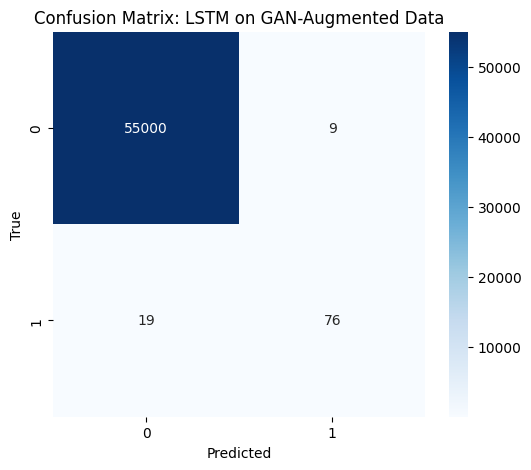

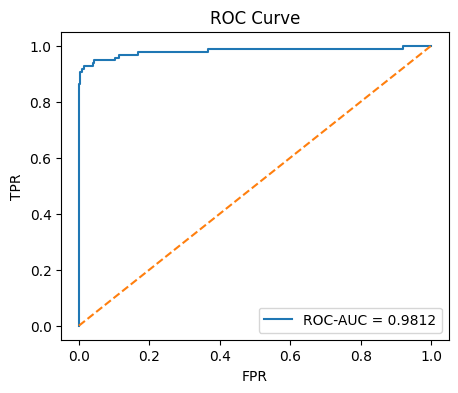

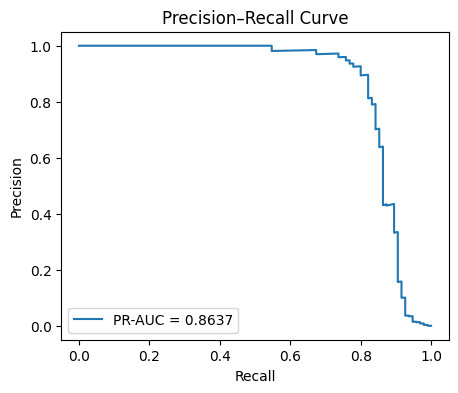

In [ ]:

import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Precision, Recall, AUC
from sklearn.metrics import (
    classification_report, confusion_matrix,
    roc_auc_score, average_precision_score, roc_curve, precision_recall_curve
)
import matplotlib.pyplot as plt
import seaborn as sns


y_train_flat = gen_y_train.ravel()  # shape (N_train,)


def create_sequences(X, y, seq_len):
    sequences, labels = [], []
    for i in range(len(X) - seq_len + 1):
        sequences.append(X[i : i + seq_len])
        labels.append(y[i + seq_len - 1])
    return np.array(sequences), np.array(labels)

SEQ_LEN = 30
BATCH   = 32
X_seq_train, y_seq_train = create_sequences(gen_X_train, y_train_flat, seq_len=SEQ_LEN)
X_seq_test,  y_seq_test  = create_sequences(X_test,       y_test,       seq_len=SEQ_LEN)


n_features = gen_X_train.shape[1]
model = Sequential([
    tf.keras.Input(shape=(SEQ_LEN, n_features)),
    LSTM(50),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])
model.compile(
    optimizer=Adam(2e-4),
    loss='binary_crossentropy',
    metrics=[
        Precision(name='precision'),
        Recall(name='recall'),
        AUC(name='roc_auc'),
        AUC(name='pr_auc', curve='PR')
    ]
)
model.summary()


history = model.fit(
    X_seq_train, y_seq_train,
    epochs=5,
    batch_size=BATCH,
    validation_data=(X_seq_test, y_seq_test),
    verbose=2
)


y_prob = model.predict(X_seq_test, batch_size=BATCH).ravel()
y_pred = (y_prob >= 0.5).astype(int)
y_true = y_seq_test

# Metrics
roc = roc_auc_score(y_true, y_prob)
pr  = average_precision_score(y_true, y_prob)
print(f"\nTest ROC-AUC: {roc:.4f}")
print(f"Test PR-AUC:  {pr:.4f}\n")

print("Classification Report:")
print(classification_report(y_true, y_pred, digits=4))


cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=[0,1], yticklabels=[0,1])
plt.xlabel("Predicted"); plt.ylabel("True")
plt.title("Confusion Matrix: LSTM on GAN-Augmented Data")
plt.show()

fpr, tpr, _ = roc_curve(y_true, y_prob)
plt.figure(figsize=(5,4))
plt.plot(fpr, tpr, label=f"ROC-AUC = {roc:.4f}")
plt.plot([0,1], [0,1], linestyle="--")
plt.xlabel("FPR"); plt.ylabel("TPR"); plt.title("ROC Curve"); plt.legend()
plt.show()


prec, rec, _ = precision_recall_curve(y_true, y_prob)
plt.figure(figsize=(5,4))
plt.plot(rec, prec, label=f"PR-AUC = {pr:.4f}")
plt.xlabel("Recall"); plt.ylabel("Precision"); plt.title("Precision–Recall Curve"); plt.legend()
plt.show()


Note- ChatGPT used for understanding results and help with lstm code to use less memory.

The Wasserstein GAN (WGAN) combined with LSTM demonstrates strong performance for fraud detection, achieving a balance of high detection ability and stable generalization.

The confusion matrix shows 76 fraud cases correctly detected, with 19 missed (false negatives) and only 9 false positives out of over 55,000 legitimate transactions.

For the fraud class, the model achieves precision = 0.8941 and recall = 0.8000, resulting in a robust F1-score = 0.8444.

Overall accuracy remains extremely high at 99.95%, confirming reliability in handling highly imbalanced data.

The ROC-AUC of 0.9812 and PR-AUC of 0.8637 indicate strong discriminatory power and effectiveness in ranking fraud cases higher than legitimate ones.

Overall, WGAN + LSTM outperforms WCGAN + LSTM, showing better recall and F1-score, while achieving a higher ROC-AUC and PR-AUC. This makes it one of the most effective GAN-LSTM combinations for fraud detection in your experiments.

Referneces-[A hybrid deep learning approach with generative adversarial network for credit card fraud detection](https://doi.org/10.3390/technologies12100186), [Improving detection of credit card fraudulent transactions using generative adversarial networks](https://arxiv.org/abs/1907.03355), [Generative adversarial network for oversampling data in credit card fraud detection](https://link.springer.com/chapter/10.1007/978-3-030-36945-3_7),[ The importance of future information in credit card fraud detection](https://arxiv.org/abs/2204.05265), https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud/code,https://www.kaggle.com/code/shiratorizawa/wcgan
